# Embeddings Overview

In [8]:
!pip install torch torchvision seaborn tqdm

You should consider upgrading via the '/Users/leandro/Library/Caches/pypoetry/virtualenvs/whylogs-vWIOXmxX-py3.8/bin/python -m pip install --upgrade pip' command.


## Why Semantic Information is important 

Outline:

- Why Semantic Information is important
- Image Embeddings
    - Pair correlation
    - Semantic centers
- Cifar-10 example
- People vs Packages Use Case

<!-- The idea is to extract images from 2 different groups: "Horse" vs "Automobile" in order to get the cluster center coordinates from the trainset.

Simulating the production stage, to simulate a data drift, we could:
- Log a batch with only one main category (e.g. "Horse")
- Add an unseen categories in the training phase ("Bird")

And check the histogram of distances to each cluster center to see if there's any difference between the expected distribution (if we had logged images of, and only of, both large land animals and vehicles)
 -->

## Embeddings

We will start by looking at embeddings of images from deep convolution networks architectures, in this case a DenseNet. Embeddings, or latent vectors, are projections of the feature space somewhere in the network. The idea is that as we go deeper in the networks features are becoming more abstract and hence contain more context related the interpertation of the data (in relation to the tasked they were trained) 

One problem, is that in order for networks to be more adaptable, and generalizable we tend to use a large feature spaces. For example right before the fully connected layers a Denset-121 has a embedding vector of 1024 dimensions. 

Large dimensional spaces come with a varied of problems besides memory and computation cost. To make distance in these spaces meaningful and easily explainable, it is convinient to normalize them, and using the dot product as a measure of distance, this equivalent to using the cosine distance since the vector are normalized. 

What information about these vectors can we monitor to ensure, or potentially forsee changes in our data ? Or beware of model degregation ? They should contain information about the semantic meaning of our data, or at the very least the semantic information learned from our models. This could come in a variaty of ways, somce which 


One particular field where classical image analysis took off, medical imaging, Image Quality Assesment became a important part of the process of image analysis since methods were not as generalizable and as such were more suspectible to noise, or other quality problems not forseen by the implementation. 


In [9]:
import torch
from tqdm import tqdm
from torch import optim, nn
from torchvision import models, transforms,datasets

# Feature Extractor

In [4]:
class ImageModel(nn.Module):
    def __init__(self, pretrained, nrof_densenet_blocks_retrain, unlock_norms=False):
        super().__init__()
        self.pretrained = pretrained
        self.nrof_densenet_blocks_retrain = nrof_densenet_blocks_retrain
        self.unlock_norms = unlock_norms
        self.net = self.load_image_model()
    def forward(self, images):
        return self.net(images).squeeze(3).squeeze(2)
    def load_image_model(self):
        net = models.densenet121(pretrained=self.pretrained)
        if self.nrof_densenet_blocks_retrain != 5:
            stop_layer = [4, 3, 2, 1, 0, -1][self.nrof_densenet_blocks_retrain]
            for name, param in net.named_parameters():
                if "classifier" in name:
                    continue
                layer = int(name.split(".")[1][-1])
                layer = min(layer, 4)
                if layer <= stop_layer:
                    if not (self.unlock_norms and "norm" in name):
                        param.requires_grad = False
        return nn.Sequential(*(list(net.children())[:-1]) + [nn.AdaptiveAvgPool2d((1,1))])

In [5]:
model = models.densenet121(pretrained=True)
feature_extractor = ImageModel(model,2)

# Dataset

In [6]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = datasets.CIFAR10('./data',
    download=True,
    train=True,
    transform=preprocess)

# dataloader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=500,
                                        shuffle=True, num_workers=1)

Files already downloaded and verified


# Train Set

## Generate Features

Let's get 10 batches of 500 images and select only the classes we want. Then we generate the feature embeddings and associated labels from the original dataset.

In [43]:
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck')
classes_tokeep = ('automobile','horse','bird', 'cat', 'deer','ship')

# features = torch.empty(0, 1024)
# labels = torch.empty(0)
features = []
labels = []
for i in tqdm(range(15)):
    images, lbs = iter(trainloader).next()
    tuples = [(x,y) for x,y in zip(images,lbs) if classes[y] in classes_tokeep]
    images = torch.stack([x[0] for x in tuples])
    lbs = torch.tensor([x[1] for x in tuples])
    class_labels = [classes[lab] for lab in lbs]

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        new_model.to('cuda')

    with torch.no_grad():
        ft = feature_extractor(images)
    features.extend(ft)
    labels.extend(lbs)
    print(i)


  7%|▋         | 1/15 [00:57<13:21, 57.28s/it]

0


 13%|█▎        | 2/15 [01:50<11:50, 54.64s/it]

1


 20%|██        | 3/15 [02:46<11:06, 55.53s/it]

2


 27%|██▋       | 4/15 [03:36<09:46, 53.35s/it]

3


 33%|███▎      | 5/15 [04:27<08:46, 52.60s/it]

4


 40%|████      | 6/15 [05:19<07:49, 52.12s/it]

5


 47%|████▋     | 7/15 [06:12<07:00, 52.61s/it]

6


 53%|█████▎    | 8/15 [07:06<06:09, 52.84s/it]

7


 60%|██████    | 9/15 [07:57<05:14, 52.35s/it]

8


 67%|██████▋   | 10/15 [08:48<04:19, 51.98s/it]

9


 73%|███████▎  | 11/15 [09:41<03:28, 52.21s/it]

10


 80%|████████  | 12/15 [10:32<02:35, 51.95s/it]

11


 87%|████████▋ | 13/15 [11:22<01:42, 51.36s/it]

12


 93%|█████████▎| 14/15 [12:13<00:51, 51.36s/it]

13


100%|██████████| 15/15 [13:01<00:00, 52.09s/it]

14


In [10]:
# import pickle
# features = []
# labels = []
# with open("features.pkl","wb") as f:
#     pickle.dump(features,f)
    
# with open("labels.pkl","wb") as f:
#     pickle.dump(labels,f)

Let's split the extracted embedding and labels into a train-test

In [44]:
import numpy as np
from sklearn.model_selection import train_test_split

features,features_p,labels,labels_p = train_test_split(features,labels)
features = nn.functional.normalize(torch.stack(features), p=2, dim=1)
features_p = nn.functional.normalize(torch.stack(features_p), p=2, dim=1)

## Reduce and Clusterize

In [45]:
import pandas as pd
df = pd.DataFrame()
df['features'] = features
df['labels'] = [x.item() for x in labels]

df_p = pd.DataFrame()
df_p['features'] = features_p
df_p['labels'] = [x.item() for x in labels_p]

In [46]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import pandas as pd

In [48]:
features_np = features.numpy()
pca = PCA(n_components=50)
ft_pca = pca.fit_transform(features_np)

df['pca-one'] = ft_pca[:,0]
df['pca-two'] = ft_pca[:,1] 
df['pca-three'] = ft_pca[:,2]

featuresp_np = features_p.numpy()
ftp_pca = pca.transform(featuresp_np)

df_p['pca-one'] = ftp_pca[:,0]
df_p['pca-two'] = ftp_pca[:,1] 
df_p['pca-three'] = ftp_pca[:,2]


print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


Explained variation per principal component: [0.0477424  0.03033316 0.02672027 0.02431328 0.02193489 0.01744225
 0.01631691 0.01439419 0.0132455  0.01289633 0.01214185 0.01113526
 0.01031784 0.01000066 0.00967996 0.00939519 0.00869171 0.0085916
 0.00837706 0.008041   0.00790423 0.00753237 0.00722682 0.00716797
 0.00698632 0.00676809 0.00659985 0.00649049 0.0064094  0.0060803
 0.00596995 0.0058879  0.00579991 0.00573626 0.00560346 0.00543212
 0.00529727 0.00524768 0.00512461 0.00506109 0.00493351 0.00487807
 0.00480083 0.00464955 0.00456718 0.00454538 0.00444287 0.00437155
 0.00431895 0.00426647]


Let's plot the firt 2 components and annotate the location of each center:

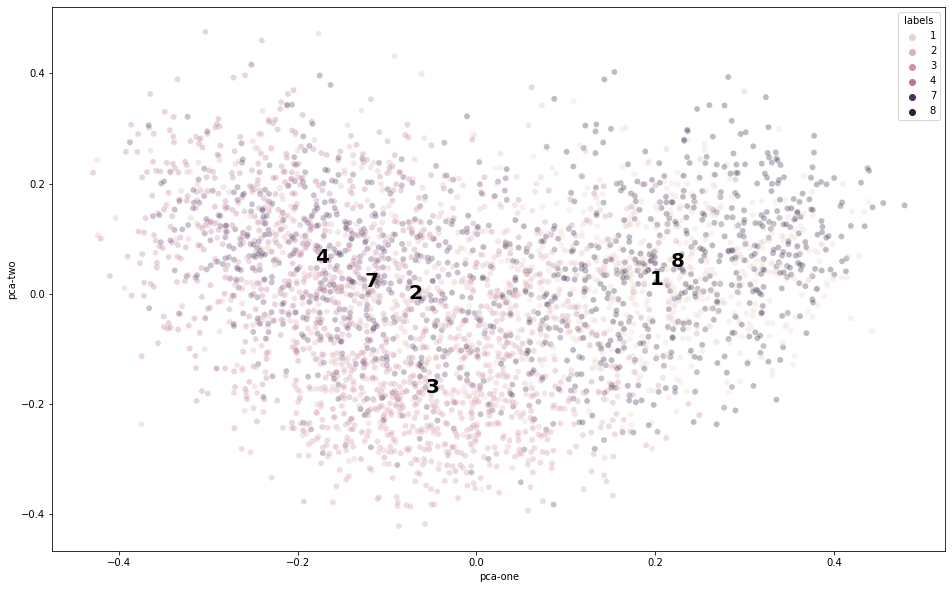

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
rndperm = np.random.permutation(df.shape[0])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="labels",
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)
# Annotate center of each cluster
for i in range(0,9):
    plt.annotate(i, 
                     df.loc[df['labels']==i,['pca-one','pca-two']].mean(),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=20, weight='bold') 

Let's see if the points from the test set behave the way we expect to:

### Pair Correlations

One particular 


### Semantic Centers

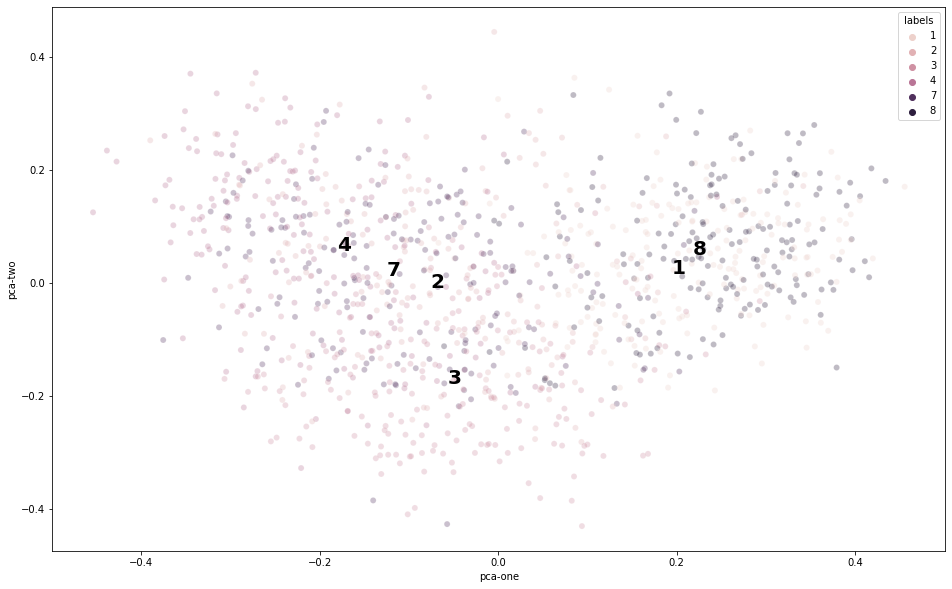

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
rndperm = np.random.permutation(df_p.shape[0])

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="labels",
#     palette=sns.color_palette("husl", 2),
    data=df_p.loc[rndperm,:],
    legend="full",
    alpha=0.3
)
# Annotate center of each cluster
for i in range(0,9):
    plt.annotate(i, 
                     df.loc[df['labels']==i,['pca-one','pca-two']].mean(),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=20, weight='bold') 

Simulating a scenario where we only have images from one category:

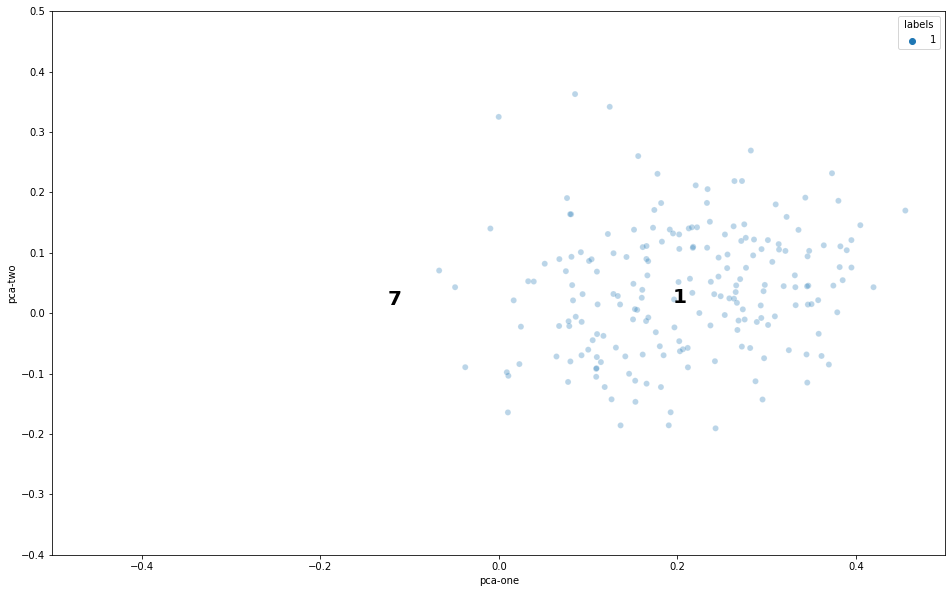

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
rndperm = np.random.permutation(df_p.shape[0])

plt.figure(figsize=(16,10))
plt.xlim([-0.5, 0.5])
plt.ylim([-0.4, 0.5])
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="labels",
#     palette=sns.color_palette("husl", 1),
    data=df_p[df_p['labels']==1],
    legend="full",
    alpha=0.3
)
# Annotate center of each cluster
for i in [1,7]:
    plt.annotate(i, 
                     df.loc[df['labels']==i,['pca-one','pca-two']].mean(),
                     horizontalalignment='center',
                     verticalalignment='center',
                     size=20, weight='bold') 

# Production Stage

## Case 1 - Batch with only one group

Calculating the coordinates for centers of both groups `c1` and `c7`

In [59]:
features_1 = torch.stack([x for i,x in enumerate(features) if labels[i]==1 ])
for i in range(10):
    torch.stack([x for i,x in enumerate(features) if labels[i]==1 ])
    c1 = torch.mean(features_1,0)
c1.size()

torch.Size([1024])

In [60]:
features_7 = torch.stack([x for i,x in enumerate(features) if labels[i]==7 ])
c7 = torch.mean(features_7,0)
c7.size()

torch.Size([1024])

Calculating the distance (dot product) between each embedding in the test set and centers of both categories:

In [33]:
# Distances between train set and cluster centers
dist_1 = [torch.dot(x,c1).item() for x in features]
dist_7 = [torch.dot(x,c7).item() for x in features]

# dist_1 = [torch.dot(x,c1).item() for i,x in enumerate(features_p)]
# dist_7 = [torch.dot(x,c7).item() for i,x in enumerate(features_p)]

# Distances between test set, with only one category "Horse", and cluster centers
dist_p1 = [torch.dot(x,c1).item() for i,x in enumerate(features_p) if labels_p[i]==7]
dist_p7 = [torch.dot(x,c7).item() for i,x in enumerate(features_p) if labels_p[i]==7]

# dist_p1 = [torch.dot(x,c1).item() for i,x in enumerate(features_p)]
# dist_p7 = [torch.dot(x,c7).item() for i,x in enumerate(features_p)]


[0.17042507231235504,
 0.2129431962966919,
 0.22449064254760742,
 0.19598861038684845,
 0.13641376793384552,
 0.24507813155651093,
 0.27109554409980774,
 0.29645904898643494,
 0.25392580032348633,
 0.2755275368690491,
 0.2529647946357727,
 0.24741485714912415,
 0.30369818210601807,
 0.28904691338539124,
 0.307974636554718,
 0.19186410307884216,
 0.17146170139312744,
 0.17493374645709991,
 0.2829854488372803,
 0.32672762870788574,
 0.11368265002965927,
 0.21547073125839233,
 0.2925056219100952,
 0.29045313596725464,
 0.20046353340148926,
 0.18512819707393646,
 0.2699890732765198,
 0.16407379508018494,
 0.21265588700771332,
 0.27566927671432495,
 0.1452510952949524,
 0.23555594682693481,
 0.255568265914917,
 0.2698711156845093,
 0.1794980764389038,
 0.28451433777809143,
 0.25903356075286865,
 0.2590813934803009,
 0.27680379152297974,
 0.23209208250045776,
 0.15620943903923035,
 0.29912906885147095,
 0.2751310169696808,
 0.1759127378463745,
 0.14074420928955078,
 0.16620147228240967,
 0.1

<ipython-input-101-9478de30505b>:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts_1, bins=np.histogram(dist_1,linear_bins,normed=True)
<ipython-input-101-9478de30505b>:3: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  counts_7, bins=np.histogram(dist_7,linear_bins,normed=True)
<ipython-input-101-9478de30505b>:4: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has

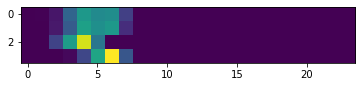

In [101]:
linear_bins=np.linspace(0,1,25)
counts_1, bins=np.histogram(dist_1,linear_bins,normed=True)
counts_7, bins=np.histogram(dist_7,linear_bins,normed=True)
counts_1_p, bins=np.histogram(dist_p1,linear_bins,normed=True)
counts_7_p, bins=np.histogram(dist_p7,linear_bins,normed=True)
plt.imshow(np.array([counts_1,counts_7,counts_1_p,counts_7_p]))
plt.show()

In [ ]:
def array_display(embeddings, centers):
    

In [77]:
print(len(counts_1))
len(np.diff(bins,1))

99


99

Plotting Histograms:
    - Train set x Cluster Center 1
    - Test set x Cluster Center 1
    - Train set x Cluster Center 7
    - Teste set x Cluster Center 7

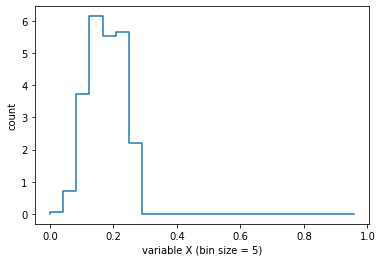

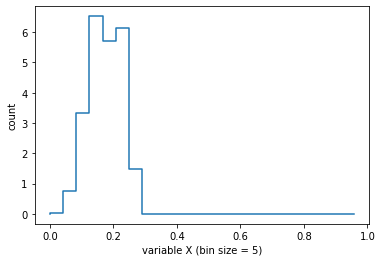

ValueError: x and y must have same first dimension, but have shapes (24,) and (1129,)

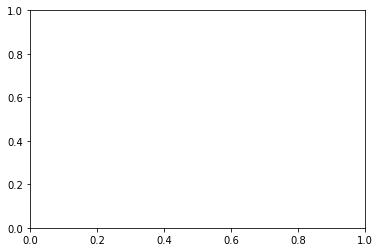

In [102]:
import numpy as np
import random
from matplotlib import pyplot as plt
dists = [counts_1,counts_7,counts_1_pta,dist_p7]
# fixed bin size
for dist_n in dists:
#     bins = np.arange(0, 1, 0.025) # fixed bin size

#     plt.xlim([min(dist_n)-0.2, max(dist_n)+0.2])

    plt.step(bins[0:-1], dist_n)
    plt.title('')
    plt.xlabel('variable X (bin size = 5)')
    plt.ylabel('count')

    plt.show()